In [1]:
location="phys"

In [2]:
import sys

#remove problematic cmssw python packages
newpath = []
for x in sys.path:
    if "/cvmfs/cms.cern.ch/" and "pandas" in x:
        continue
    newpath += [x]
sys.path = newpath

from collections import OrderedDict

if location=="jpata-macbook":
    sys.path.append("/Users/joosep/Documents/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
    sys.path.append("/Users/joosep/Documents/ROOTDataHelpers/python/")
elif location=="phys":
    sys.path.append("/home/joosep/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
    sys.path.append("/home/joosep/btv/CMSSW_7_4_5/src/RecoBTag/ROOTDataHelpers/python/")

import numpy as np
import root_numpy as rnpy
import matplotlib.pyplot as plt
import pandas
import sklearn
import sklearn_cls
from sklearn_cls import SKLearnClassifier
from matplotlib.colors import LogNorm
import rootpy
import rootpy.plotting
from sklearn import metrics
%matplotlib inline
import ROOT

In [196]:
sklearn.__version__

'0.16.1'

In [199]:
rootpy.__version__

'0.7.1'

In [201]:
rnpy.__version__

'4.3.0.dev0'

In [3]:
import rootpy.plotting.root2matplotlib as rplt

Here we define the pt/eta binning for the kinematic weighting and for studying the pt/eta dependent performance of the tagger

In [4]:
ptbins = np.linspace(20, 620, 41)
ptbins2 = np.array([20, 30, 40, 50, 60, 70, 80, 100, 120, 140, 160, 200, 240, 280, 320, 360])

etabins = np.linspace(0, 2.5, 41)
etabins2 = np.linspace(0, 2.5, 11)

We load and pre-process the datasets. In particular, ***we clamp the CSV and SoftEl/SoftMu values between 0 and 1***.

In [5]:
def load_dataset(fn, treename, i):
    arr = rnpy.root2rec(
        fn,
        selection="Jet_pt>20",
        #branches=["Jet_pt", "Jet_eta", "Jet_flavour"],
        branches=["Jet_pt", "Jet_eta", "Jet_flavour", "Jet_CSV", "Jet_CSVIVF", "Jet_CombMVA", "Jet_CombMVANEW", "Jet_CombMVAETH", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP", "Jet_JBP", "TagVarCSV_vertexCategory"],
        treename=treename,
        #start=0,
        #stop=50000 #load only this many events for testing
    )
    df = pandas.DataFrame(arr)
    
    df["id"] = i
    df["label"] = 0
    
    df[np.isnan(df)] = 0.0
    df[np.isinf(df)] = 0.0
    for c in ["Jet_CSV", "Jet_CSVIVF", "Jet_SoftEl", "Jet_SoftMu"]:
        df.loc[df[c]<=0, c] = 0
        df.loc[df[c]>=1, c] = 1
    df["abs_eta"] = df["Jet_eta"].abs()
    df["training"] = 0
    
    #shuffle jets randomly between testing and training with a 50% probability
    perminds = np.random.permutation(df.index)
    df.loc[perminds[:len(perminds)/2], "training"] = 1
    df["ptbin"] = map(lambda x: ptbins.searchsorted(x), df["Jet_pt"])
    df["ptbin2"] = map(lambda x: ptbins2.searchsorted(x), df["Jet_pt"])
    df["etabin"] = map(lambda x: etabins.searchsorted(x), df["abs_eta"])
    df["etabin2"] = map(lambda x: etabins2.searchsorted(x), df["abs_eta"])
    df["w"] = 1.0
    return df

Now we load all the datasets.
We have defined the jet flavours as follows:
  * flavour "0" - udsg
  * flavour "1" - c
  * flavour "2" - b

In [6]:
if location == "jpata-macbook":
    path = "../data/aug10/"
elif location == "phys":
    path = "/home/joosep/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/"
d1 = load_dataset(path + "ttjets_b_10M.root", "tree_b", 2)
d2 = load_dataset(path + "ttjets_c_10M.root", "tree_c", 1)
d3 = load_dataset(path + "ttjets_l_10M.root", "tree_l", 0)

In [7]:
d = pandas.concat((d1, d2, d3))

In [8]:
d.shape

(27077224, 22)

Set b-jets to have label (training output) to 1, other jets to 0.

In [9]:
d.loc[d["id"]==2, "label"] = 1

Let's take a quick look at what we have.

In [10]:
d.head()

,Jet_pt,Jet_eta,Jet_flavour,Jet_CSV,Jet_CSVIVF,Jet_CombMVA,Jet_CombMVANEW,Jet_CombMVAETH,Jet_SoftMu,Jet_SoftEl,...,TagVarCSV_vertexCategory,id,label,abs_eta,training,ptbin,ptbin2,etabin,etabin2,w
0,85.697235,-0.748034,-5,0.940766,0.997546,0.874445,0.920242,0.996999,0.0000,0.000000,...,0,2,1,0.748034,1,5,7,12,3,1
1,40.214520,0.974156,5,0.982968,0.932280,0.867366,0.900051,0.996791,0.0000,0.961287,...,0,2,1,0.974156,1,2,3,16,4,1
2,67.870689,0.875932,5,0.980145,0.996056,0.997501,0.968549,0.999658,0.5273,0.000000,...,0,2,1,0.875932,0,4,5,15,4,1
3,51.846420,2.362511,5,0.230944,0.230944,0.464971,0.361609,-0.944599,0.0000,0.000000,...,2,2,1,2.362511,1,3,4,38,10,1
4,64.102722,1.035905,5,0.995930,0.984237,0.999932,0.919411,0.999732,0.0000,0.206347,...,0,2,1,1.035905,1,3,5,17,5,1


Now we also load the QCD datasets.

In [11]:
d1_qcd = load_dataset(path + "qcd_b_10M.root", "tree_b", 2)
d2_qcd = load_dataset(path + "qcd_c_10M.root", "tree_c", 1)
d3_qcd = load_dataset(path + "qcd_l_10M.root", "tree_l", 0)
d_qcd = pandas.concat((d1_qcd, d2_qcd, d3_qcd))

In [12]:
# d_training_shuf.head(1000).to_csv("/Users/joosep/Desktop/data.csv")

In [13]:
#d.to_csv("/Users/joosep/Desktop/data.csv")

We split to training and testing according to a jet-by-jet random shuffle defined when the datasets are loaded. 

In [14]:
d_training = d[d["training"]==1]
d_testing = d[d["training"]==0]

Now we calculate the kinematic weights.

In [15]:
ptbins_w = np.linspace(20, 620, 101)
etabins_w = np.linspace(0, 2.5, 101)
def get_weights(df):
    vs, bx, by = np.histogram2d(
        df["Jet_pt"],
        df["abs_eta"],
        bins=[ptbins_w, etabins_w]
    )
    vs = vs / float(np.sum(vs))
    ws = 1.0/vs
    ws[np.isnan(ws)]=0.0
    ws[np.isnan(ws)]=0.0
    ws[np.isinf(ws)]=1
    ws[np.isinf(ws)]=1
    return ws

In [16]:
weight_b = get_weights(d[d["id"]==2])
weight_c = get_weights(d[d["id"]==1])
weight_l = get_weights(d[d["id"]==0])

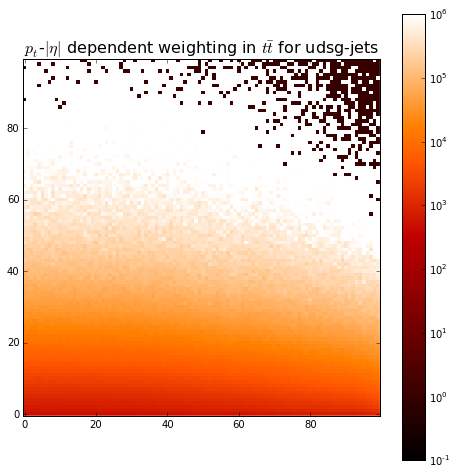

In [190]:
plt.figure(figsize=(8,8))
plt.title("$p_t$-$|\eta|$ dependent weighting in $t\\bar{t}$ for udsg-jets", fontsize=16)
z = plt.imshow(weight_l, interpolation="none",origin="lower",norm=LogNorm(vmin=0.1,vmax=1000000.0), cmap="gist_heat")
plt.colorbar(z)
plt.savefig("weights_light.pdf")

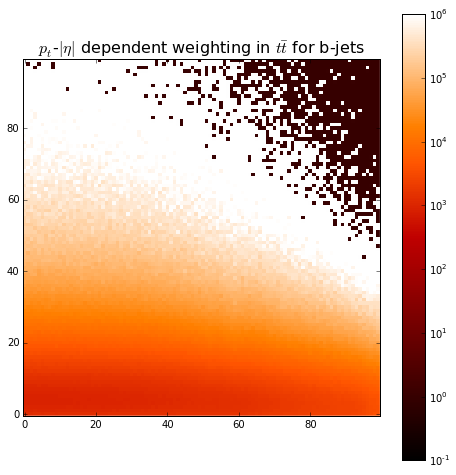

In [191]:
plt.figure(figsize=(8,8))
plt.title("$p_t$-$|\eta|$ dependent weighting in $t\\bar{t}$ for b-jets", fontsize=16)
z = plt.imshow(weight_b, interpolation="none",origin="lower",norm=LogNorm(vmin=0.1,vmax=1000000.0), cmap="gist_heat")
plt.colorbar(z)
plt.savefig("weights_b.pdf")

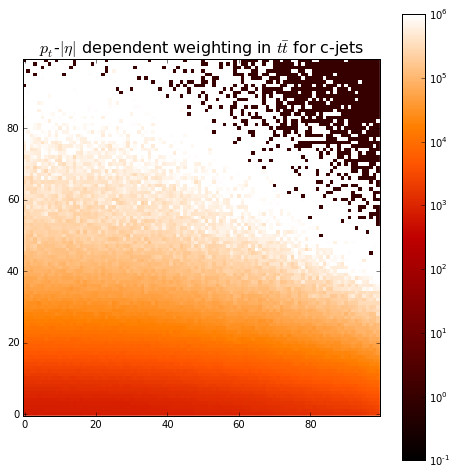

In [192]:
plt.figure(figsize=(8,8))
plt.title("$p_t$-$|\eta|$ dependent weighting in $t\\bar{t}$ for c-jets", fontsize=16)
z = plt.imshow(weight_c, interpolation="none",origin="lower",norm=LogNorm(vmin=0.1,vmax=1000000.0), cmap="gist_heat")
plt.colorbar(z)
plt.savefig("weights_charm.pdf")

In [20]:
def weight(pt, eta, fl):
    ibx = ptbins_w.searchsorted(pt) - 1
    iby = etabins_w.searchsorted(abs(eta)) - 1
    if ibx < 0:
        ibx = 0
    if iby < 0:
        iby = 0
    if ibx>=len(ptbins_w)-1:
        ibx = len(ptbins_w)-2
    if iby>=len(etabins_w)-1:
        iby = len(etabins_w)-2
        
    if fl == 2:
        ws = weight_b
    elif fl == 1:
        ws = weight_c
    elif fl==0:
        ws = weight_l
    return ws[ibx, iby]  

In [21]:
d["w"]  = map(
    lambda _z: weight(_z[0], _z[1], _z[2]),
    zip(d["Jet_pt"], d["abs_eta"], d["id"])
)

d["w2"] = 1
d.loc[d["id"]==0, "w2"] = 0.5
d.loc[d["id"]==1, "w2"] = 0.5

In [22]:
d_training_shuf = d_training.iloc[np.random.permutation(len(d_training))]

In [179]:
def draw_corr(data, v1, vn1, v2, vn2, title):

    c = (np.abs(data["Jet_CSV"] -
         data["Jet_CSVIVF"])>0.00000000001
    )
    hd = np.histogram2d(
        data[c][v1],
        data[c][v2],
        bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
    )
    hd = hd[0] / float(np.sum(hd[0]))
    corr = np.corrcoef(
        data[c][v1],
        data[c][v2]
    )

    plt.figure(figsize=(6,5))
    ax = plt.axes()
    ret = ax.imshow(
        hd,
        cmap="hot",
        interpolation="none",
        origin="lower",
        aspect="auto",
        #vmin=0,
        #vmax=60000,
        extent=[
            0,
            1,
            0,
            1
        ],
        norm=LogNorm(vmin=0.000001, vmax=1)
    )
    plt.title(title + " corr={0:.4f}".format(corr[0,1]), fontsize=16)
    plt.xlabel(vn1, fontsize=16)
    plt.ylabel(vn2, fontsize=16)
    plt.colorbar(ret)

Pt distribution before and after reweighting.

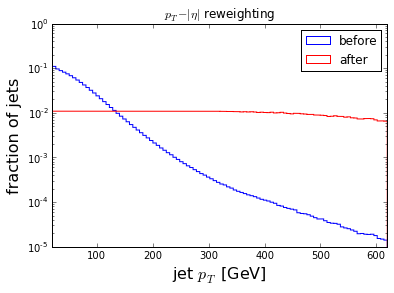

In [189]:
h = rootpy.plotting.Hist(100, 20, 620)
w = np.ones(len(d), dtype="float64")
h.FillN(len(d), np.array(d["Jet_pt"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(100, 20, 620)
h2.FillN(len(d), np.array(d["Jet_pt"]).astype("float64"), np.array(d["w"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

plt.yscale("log")
plt.ylim(10**-5, 1)
plt.xlabel("jet $p_T$ [GeV]", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("pt_reweight.pdf")

Eta distribution before and after reweighting.

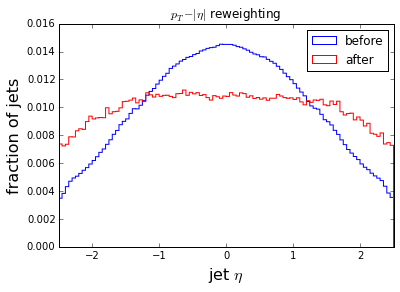

In [178]:
h = rootpy.plotting.Hist(100, -2.5, 2.5)
w = np.ones(len(d), dtype="float64")
h.FillN(len(d), np.array(d["Jet_eta"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(100, -2.5, 2.5)
h2.FillN(len(d), np.array(d["Jet_eta"]).astype("float64"), np.array(d["w"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $\eta$", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("eta_reweight.pdf")

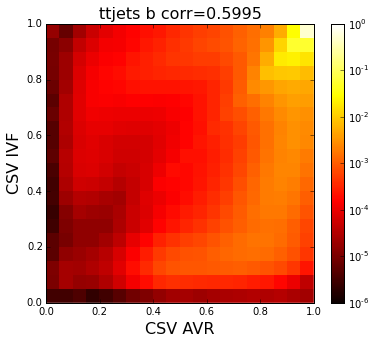

In [193]:
draw_corr(d[d["id"]==2], "Jet_CSV", "CSV AVR", "Jet_CSVIVF", "CSV IVF", "ttjets b")
plt.savefig("corr_csv_avr_ivf_b.pdf")

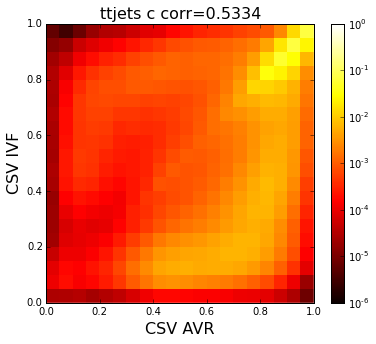

In [194]:
draw_corr(d[d["id"]==1], "Jet_CSV", "CSV AVR", "Jet_CSVIVF", "CSV IVF", "ttjets c")
plt.savefig("corr_csv_avr_ivf_charm.pdf")

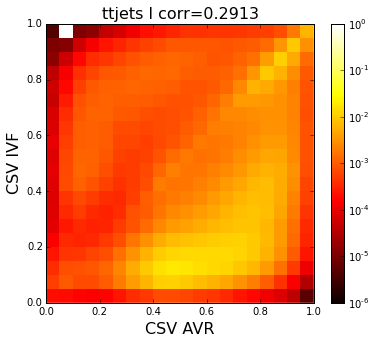

In [195]:
draw_corr(d[d["id"]==0], "Jet_CSV", "CSV AVR", "Jet_CSVIVF", "CSV IVF", "ttjets l")
plt.savefig("corr_csv_avr_ivf_light.pdf")

In [29]:
def cum(arr, nb=100000):
    h = np.histogram(
        arr,
        bins=np.linspace(-1, 1, nb)
    )
    h = h[0]
    h = h / float(np.sum(h))
    h = np.cumsum(h)
    return h

In [30]:
def cumerr(arr, nb=100000):
    h = np.histogram(
        arr,
        bins=np.linspace(np.min(arr), np.max(arr),nb)
    )
    h = h[0]
    hc = np.cumsum(h)
    he = np.sqrt(np.cumsum(h))
    hc = hc / float(np.sum(h))
    he = he / float(np.sum(h))
    return hc, he

In [31]:
md = {
    "b":d_testing[d_testing["id"]==2][:10000],
    "l":d_testing[d_testing["id"]==0][:10000],
    "c":d_testing[d_testing["id"]==1][:10000]
}

Set light-jet weight to 30% to give less emphasis to udgs.
**Note: we de-emphasize the effect of light jets in the training**

In [183]:
d_training.loc[d_training["id"]==0, "w"] *= 0.3

In [33]:
cls_ca = SKLearnClassifier(
    name="c1",
    data_name="ttjets",
    variables=["Jet_CSVIVF"],
    ntrees=200, label="label"
)
cls_ca.add_data(d_training_shuf[d_training_shuf["id"] == 2][:1000000], "b")
cls_ca.add_data(d_training_shuf[d_training_shuf["id"] == 1][:1000000], "udsg")
cls_ca.add_data(d_training_shuf[d_training_shuf["id"] == 0][:1000000], "c")

cls_ca.prepare()
cls_ca.train()

      Iter       Train Loss   Remaining Time 
         1           1.1913           17.90m
         2           1.1276           16.47m
         3           1.0764           15.96m
         4           1.0346           15.64m
         5           0.9998           15.45m
         6           0.9708           15.28m
         7           0.9465           15.13m
         8           0.9259           15.00m
         9           0.9084           14.85m
        10           0.8936           14.68m
        20           0.8242           13.61m
        30           0.8083           12.86m
        40           0.8045           12.11m
        50           0.8037           11.34m
        60           0.8035           10.61m
        70           0.8034            9.96m
        80           0.8034            9.28m
        90           0.8034            8.57m
       100           0.8034            7.82m
       200           0.8032            0.00s


In [34]:
cls_c0 = SKLearnClassifier(
    name="c1",
    data_name="ttjets",
    variables=["Jet_CSVIVF", "Jet_SoftEl", "Jet_SoftMu"],
    ntrees=200, label="label"
)
cls_c0.add_data(d_training_shuf[d_training_shuf["id"] == 2][:1000000], "b")
cls_c0.add_data(d_training_shuf[d_training_shuf["id"] == 1][:1000000], "udsg")
cls_c0.add_data(d_training_shuf[d_training_shuf["id"] == 0][:1000000], "c")

cls_c0.prepare()
cls_c0.train()

      Iter       Train Loss   Remaining Time 
         1           1.1910           33.90m
         2           1.1269           30.23m
         3           1.0752           29.34m
         4           1.0325           28.36m
         5           0.9969           27.91m
         6           0.9673           27.20m
         7           0.9419           26.40m
         8           0.9207           25.72m
         9           0.9021           25.59m
        10           0.8865           25.47m
        20           0.8091           23.11m
        30           0.7883           21.68m
        40           0.7812           19.92m
        50           0.7780           18.81m
        60           0.7765           17.59m
        70           0.7756           16.35m
        80           0.7749           14.72m
        90           0.7742           13.21m
       100           0.7739           11.90m
       200           0.7726            0.00s


In [35]:
cls_c1 = SKLearnClassifier(
    name="c1",
    variables=["Jet_CSVIVF", "Jet_JP", "Jet_SoftEl", "Jet_SoftMu"],
    ntrees=200, label="label"
)
cls_c1.add_data(d_training_shuf[d_training_shuf["id"] == 2][:1000000], "b")
cls_c1.add_data(d_training_shuf[d_training_shuf["id"] == 1][:1000000], "udsg")
cls_c1.add_data(d_training_shuf[d_training_shuf["id"] == 0][:1000000], "c")

cls_c1.prepare()
cls_c1.train()

      Iter       Train Loss   Remaining Time 
         1           1.1905           43.73m
         2           1.1257           37.90m
         3           1.0736           36.05m
         4           1.0304           35.00m
         5           0.9948           34.14m
         6           0.9643           33.63m
         7           0.9385           33.24m
         8           0.9166           32.93m
         9           0.8978           32.74m
        10           0.8815           32.43m
        20           0.8013           30.05m
        30           0.7788           28.12m
        40           0.7710           26.20m
        50           0.7668           24.26m
        60           0.7649           22.43m
        70           0.7635           20.57m
        80           0.7627           18.82m
        90           0.7620           17.14m
       100           0.7615           15.50m
       200           0.7590            0.00s


In [36]:
cls_c2 = SKLearnClassifier(
    name="c2",
    variables=["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_SoftMu", "Jet_SoftEl"],
    ntrees=200, label="label"
)
cls_c2.add_data(d_training_shuf[d_training_shuf["id"] == 2][:1000000], "b")
cls_c2.add_data(d_training_shuf[d_training_shuf["id"] == 0][:1000000], "udsg")
cls_c2.add_data(d_training_shuf[d_training_shuf["id"] == 1][:1000000], "c")

cls_c2.prepare()
cls_c2.train()

      Iter       Train Loss   Remaining Time 
         1           1.1905           39.36m
         2           1.1260           34.12m
         3           1.0735           32.23m
         4           1.0305           30.89m
         5           0.9943           30.42m
         6           0.9644           29.94m
         7           0.9385           29.57m
         8           0.9164           29.56m
         9           0.8975           29.39m
        10           0.8811           29.39m
        20           0.7987           27.75m
        30           0.7755           26.79m
        40           0.7668           25.31m
        50           0.7623           23.72m
        60           0.7602           22.48m
        70           0.7589           21.30m
        80           0.7579           20.11m
        90           0.7572           18.70m
       100           0.7565           17.19m
       200           0.7527            0.00s


In [37]:
cls_c3 = SKLearnClassifier(
    name="c3",
    variables=["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"],
    #weight="w",
    ntrees=200, label="label"
)
#sel = d_training_shuf.eval("(Jet_CSV>=-10) & (Jet_CSVIVF>=-10) & (Jet_SoftEl>=-10) & (Jet_SoftMu>=-10) & (Jet_JP>=-10) & (Jet_JBP>=-10)")
cls_c3.add_data(d_training_shuf[d_training_shuf["id"] == 2][:1000000], "b")
cls_c3.add_data(d_training_shuf[d_training_shuf["id"] == 0][:1000000], "udsg")
cls_c3.add_data(d_training_shuf[d_training_shuf["id"] == 1][:1000000], "c")

cls_c3.prepare()
cls_c3.train()

      Iter       Train Loss   Remaining Time 
         1           1.1898           75.79m
         2           1.1248           62.80m
         3           1.0721           57.63m
         4           1.0286           54.78m
         5           0.9925           53.43m
         6           0.9618           52.38m
         7           0.9358           51.42m
         8           0.9138           50.59m
         9           0.8946           49.92m
        10           0.8781           49.43m
        20           0.7949           45.28m
        30           0.7711           42.26m
        40           0.7620           39.59m
        50           0.7576           37.18m
        60           0.7552           34.63m
        70           0.7537           31.72m
        80           0.7526           29.04m
        90           0.7518           26.52m
       100           0.7510           24.03m
       200           0.7471            0.00s


## Classifier C4

This is the main training. Train on 6 variables.

In [38]:
cls_c4 = SKLearnClassifier(
    name="c4",
    variables=["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"],
    weight="w",
    ntrees=200, label="label"
)
cls_c4.add_data(d_training_shuf[d_training_shuf["id"] == 2], "b")
cls_c4.add_data(d_training_shuf[d_training_shuf["id"] == 0], "udsg")
cls_c4.add_data(d_training_shuf[d_training_shuf["id"] == 1], "c")

cls_c4.prepare()
cls_c4.train()

      Iter       Train Loss   Remaining Time 
         1           1.2296          287.11m
         2           1.1599          238.13m
         3           1.1030          221.46m
         4           1.0559          213.15m
         5           1.0163          205.52m
         6           0.9828          199.73m
         7           0.9543          196.49m
         8           0.9301          193.66m
         9           0.9090          191.01m
        10           0.8905          188.35m
        20           0.7988          164.16m
        30           0.7723          149.26m
        40           0.7625          139.60m
        50           0.7575          128.79m
        60           0.7551          118.54m
        70           0.7536          109.15m
        80           0.7524           99.62m
        90           0.7517           90.32m
       100           0.7509           80.98m
       200           0.7468            0.00s


## Classifier C5

As before, but train on the first 50k rows from each category.

In [39]:
cls_c5 = SKLearnClassifier(
    name="c5",
    data_name="ttjets",
    variables=["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"],
    weight="w",
    ntrees=200, label="label"
)
cls_c5.add_data(d_training_shuf[d_training_shuf["id"] == 2][:50000], "b")
cls_c5.add_data(d_training_shuf[d_training_shuf["id"] == 0][:50000], "udsg")
cls_c5.add_data(d_training_shuf[d_training_shuf["id"] == 1][:50000], "c")

cls_c5.prepare()
cls_c5.train()

      Iter       Train Loss   Remaining Time 
         1           1.1895            2.22m
         2           1.1240            2.00m
         3           1.0711            1.92m
         4           1.0275            1.88m
         5           0.9910            1.87m
         6           0.9604            1.86m
         7           0.9341            1.84m
         8           0.9120            1.82m
         9           0.8927            1.80m
        10           0.8765            1.79m
        20           0.7929            1.72m
        30           0.7686            1.64m
        40           0.7596            1.55m
        50           0.7550            1.46m
        60           0.7524            1.36m
        70           0.7507            1.26m
        80           0.7495            1.17m
        90           0.7483            1.06m
       100           0.7470           57.59s
       200           0.7410            0.00s


# Validation

Now we separate test and training datasets as matrices.

In [40]:
X_test = d_testing[cls_c4.variables]
y_test = d_testing["id"]

X_train = d_training[cls_c4.variables]
y_train = d_training["id"]

Now we calculate the loss function of the classifier on each stage of training.

In [41]:
test_score = np.zeros((cls_c4.cls.n_estimators, ), dtype=np.float64)

for i, y_pred in enumerate(cls_c4.cls.staged_decision_function(X_test)):
    test_score[i] = cls_c4.cls.loss_(y_test, y_pred)

In [42]:
train_score = np.zeros((cls_c4.cls.n_estimators, ), dtype=np.float64)

for i, y_pred in enumerate(cls_c4.cls.staged_decision_function(X_train)):
    train_score[i] = cls_c4.cls.loss_(y_train, y_pred)

We see that the loss function decreases (becomes better) upon more boosting iterations.

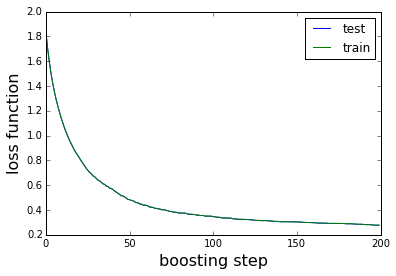

In [187]:
plt.plot(test_score, label="test")
plt.plot(train_score, label="train")
plt.legend(loc="best")
plt.xlabel("boosting step", fontsize=16)
plt.ylabel("loss function", fontsize=16)
plt.savefig("loss_test_train.pdf")

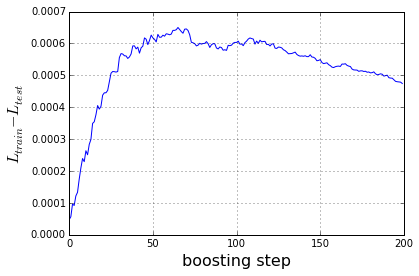

In [188]:
plt.plot(train_score - test_score)
#plt.yscale("log")
plt.ylabel("$L_{train} - L_{test}$", fontsize=16)
plt.xlabel("boosting step", fontsize=16)
plt.grid()
plt.savefig("lossdif_test_train.pdf")

In [99]:
def calc_roc(h1, h2):
    h1 = h1.Clone()
    h2 = h2.Clone()
    h1.Scale(1.0 / h1.Integral())
    h2.Scale(1.0 / h2.Integral())
    roc = np.zeros((h1.GetNbinsX()+2, 2))
    err = np.zeros((h1.GetNbinsX()+2, 2))
    e1 = ROOT.Double(0)
    e2 = ROOT.Double(0)
    for i in range(0, h1.GetNbinsX()+2):
        I1 = h1.Integral(0, h1.GetNbinsX())
        I2 = h2.Integral(0, h2.GetNbinsX())
        if I1>0 and I2>0:
            roc[i, 0] = float(h1.IntegralAndError(i, h1.GetNbinsX()+2, e1)) / I1
            roc[i, 1] = float(h2.IntegralAndError(i, h1.GetNbinsX()+2, e2)) / I2
            err[i, 0] = e1
            err[i, 1] = e2
    return roc, err
def draw_rocs(pairs, **kwargs):
    rebin = kwargs.get("rebin", 1) 
    rs = []
    es = []
    for pair in pairs:
        h1, h2, label, pl_args = pair
        h1.rebin(rebin)
        h2.rebin(rebin)
        r, e = calc_roc(h1, h2)
        rs += [r]
        es += [e]

    ret = []
    for (r, e, pair) in zip(rs, es, pairs):
        h1, h2, label, pl_args = pair
        c1 = rootpy.asrootpy(h1.GetCumulative())
        c2 = rootpy.asrootpy(h2.GetCumulative())
        c1.Scale(1.0 / h1.Integral())
        c2.Scale(1.0 / h2.Integral())
        bx = list(c1.y())
        by = list(c2.y())
        a = 1.0 - sklearn.metrics.auc(bx, by)
        #plt.errorbar(r[:, 0], r[:, 1], e[:, 0], e[:, 1], label=label)
        r = plt.plot(r[:, 0], r[:, 1], label=label, **pl_args)
        ret += [r]
    return ret
    plt.legend(loc=2)

### Performance in $t\bar{t}$ + jets.

In [ ]:
md = {"b":d_testing[d_testing["id"]==2], "l":d_testing[d_testing["id"]==0], "c":d_testing[d_testing["id"]==1]}
md_tr = {"b":d_training[d_training["id"]==2], "l":d_training[d_training["id"]==0], "c":d_training[d_training["id"]==1]}

h01 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSV"].as_matrix(), lambda d: d["w"].as_matrix())
h02 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSVIVF"].as_matrix(), lambda d: d["w"].as_matrix())
#h03 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVA"].as_matrix(), lambda d: d["w"].as_matrix())
h04 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVANEW"].as_matrix(), lambda d: d["w"].as_matrix())
h05 = cls_c1.hists((250,-1,1), md, lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix())

ha = cls_ca.hists_cls((250,-1,1), md)
h0 = cls_c0.hists_cls((250,-1,1), md)
h1 = cls_c1.hists_cls((250,-1,1), md)
h2 = cls_c2.hists_cls((250,-1,1), md)
h3 = cls_c3.hists_cls((250,-1,1), md)
h4 = cls_c4.hists_cls((250,-1,1), md)
h5 = cls_c5.hists_cls((250,-1,1), md)

In [ ]:
#h_ts = cls_c1.hists((250,-1,1), lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix(), md)
#h_tr = cls_c1.hists((250,-1,1), lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix(), md_tr)

h_ts = cls_c4.hists_cls((100,-1,1), md)
h_tr = cls_c4.hists_cls((100,-1,1), md_tr)

We compare the test and training performances.

In [ ]:
plt.figure(figsize=(6,6))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    (h_ts["b"], h_ts["l"], "testing", {"color":"red"}),
    (h_tr["b"], h_tr["l"], "training", {"color":"green", "ls": "--"}),
])

plt.legend(loc=4)
r = draw_rocs([
    (h_ts["b"], h_ts["c"], "testing", {"color":"red"}),
    (h_tr["b"], h_tr["c"], "training", {"color":"green", "ls": "--"}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in $t\\bar{t}$+jets", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("cmva_test_training_perf_roc_ttjets.pdf")

Here we compare the shapes of the test and training distributions.

In [ ]:
for k in ["b", "c", "l"]:
    h_ts[k].Rebin(5)
    h_tr[k].Rebin(5)
    h_ts[k].Divide(h_tr[k])
    
h_ts["b"].color = "red"
h_ts["c"].color = "blue"
h_ts["l"].color = "green"

In [ ]:
plt.figure(figsize=(6,6))
rplt.errorbar(h_ts["b"], label="b-jets")
rplt.errorbar(h_ts["c"], label="charm jets")
rplt.errorbar(h_ts["l"], label="light jets")

plt.ylim(0.8,1.2)
plt.axhline(1.0, color="black")
plt.grid()
plt.xlabel("cMVA v2", fontsize=16)
plt.ylabel("test/train ratio", fontsize=16)
plt.legend(numpoints=1)
plt.savefig("cmva_test_training_shape.pdf")

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    #(h01["b"], h01["l"], "AVR", {"color":"red"}),
    (h02["b"], h02["l"], "IVF", {"color":"red"}),
    #(h04["b"], h04["l"], "cMVA", {"color":"orange", "lw":2}),
    (h05["b"], h05["l"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["l"], "tmva", {"color":"orange"}),
    (ha["b"], ha["l"], "IVF bdt", {"color": "darkred", "lw":1}),
    (h0["b"], h0["l"], "IVF+SoftLep", {"color": "green", "lw":1}),
    (h1["b"], h1["l"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    (h2["b"], h2["l"], "IVF+AVR+JP+SoftLep", {"color": "black", "lw":1}),
    (h3["b"], h3["l"], "IVF+AVR+JP+JBP+SoftLep", {"color": "purple", "lw":1}),
    (h4["b"], h4["l"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["l"], "c5", {"color": "gray", "lw":1}),
])

plt.legend(loc="best")
r = draw_rocs([
    #(h01["b"], h01["c"], "AVR", {"color":"red"}),
    (h02["b"], h02["c"], "IVF", {"color":"red"}),
    #(h04["b"], h04["c"], "cMVA", {"color":"orange", "lw":2}),
    (h05["b"], h05["c"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["c"], "tmva", {"color":"orange"}),
    (ha["b"], ha["c"], "IVF bdt", {"color": "darkred", "lw":1}),
    (h0["b"], h0["c"], "IVF+SoftLep", {"color": "green", "lw":1}),
    (h1["b"], h1["c"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    (h2["b"], h2["c"], "IVF+AVR+JP+SoftEl", {"color": "black", "lw":1}),
    (h3["b"], h3["c"], "IVF+AVR+JP+JBP+SoftEl", {"color": "purple", "lw":1}),
    (h4["b"], h4["c"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["c"], "c5", {"color": "gray", "lw":1}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in $t\\bar{t}$+jets", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("mva_separate_trainings_ttjets.pdf")

In [ ]:
plt.figure(figsize=(6,6))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    #(h01["b"], h01["l"], "AVR", {"color":"red"}),
    #(h02["b"], h02["l"], "IVF", {"color":"red"}),
    (h04["b"], h04["l"], "cMVA", {"color":"orange"}),
    (h05["b"], h05["l"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["l"], "tmva", {"color":"orange"}),
    #(ha["b"], ha["l"], "IVF bdt", {"color": "darkred", "lw":1}),
    #(h0["b"], h0["l"], "IVF+SoftLep", {"color": "green", "lw":1}),
    #(h1["b"], h1["l"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    #(h2["b"], h2["l"], "IVF+AVR+JP+SoftLep", {"color": "black", "lw":1}),
    #(h3["b"], h3["l"], "IVF+AVR+JP+JBP+SoftLep", {"color": "purple", "lw":1}),
    #(h4["b"], h4["l"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["l"], "c5", {"color": "gray", "lw":1}),
])

plt.legend(loc="best")
r = draw_rocs([
    #(h01["b"], h01["c"], "AVR", {"color":"red"}),
    #(h02["b"], h02["c"], "IVF", {"color":"red"}),
    (h04["b"], h04["c"], "cMVA", {"color":"orange"}),
    (h05["b"], h05["c"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["c"], "tmva", {"color":"orange"}),
    #(ha["b"], ha["c"], "IVF bdt", {"color": "darkred", "lw":1}),
    #(h0["b"], h0["c"], "IVF+SoftLep", {"color": "green", "lw":1}),
    #(h1["b"], h1["c"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    #(h2["b"], h2["c"], "IVF+AVR+JP+SoftEl", {"color": "black", "lw":1}),
    #(h3["b"], h3["c"], "IVF+AVR+JP+JBP+SoftEl", {"color": "purple", "lw":1}),
    #(h4["b"], h4["c"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["c"], "c5", {"color": "gray", "lw":1}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in $t\\bar{t}$+jets", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("cmva_vs_cmvav2_roc_perf_ttjets.pdf")

### Performance in QCD

In [ ]:
md = {"b":d_qcd[d_qcd["id"]==2], "l":d_qcd[d_qcd["id"]==0], "c":d_qcd[d_qcd["id"]==1]}
h01_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSV"].as_matrix(), lambda d: d["w"].as_matrix())
h02_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSVIVF"].as_matrix(), lambda d: d["w"].as_matrix())
h03_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVA"].as_matrix(), lambda d: d["w"].as_matrix())
h04_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVANEW"].as_matrix(), lambda d: d["w"].as_matrix())
h05_qcd = cls_c1.hists((250,-1,1), md, lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix())

#h04 = cls_c3.hists((100,0,1), lambda d: d["tmva"].as_matrix(), md)

#h2 = cls_c3.hists_cls((100,0,1), {"b":d_training[d_training["id"]==2], "l":d_training[d_training["id"]!=2]})
h1_qcd = cls_c1.hists_cls((250,-1,1), md)
h2_qcd = cls_c2.hists_cls((250,-1,1), md)
h3_qcd = cls_c3.hists_cls((250,-1,1), md)
h4_qcd = cls_c4.hists_cls((250,-1,1), md)


In [ ]:
plt.figure(figsize=(6,6))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    #(h01_qcd["b"], h01_qcd["l"], "AVR", {"color":"red"}),
    #(h02_qcd["b"], h02_qcd["l"], "IVF", {"color":"green"}),
    (h04_qcd["b"], h04_qcd["l"], "cMVA", {"color":"orange", "lw":2}),
    (h05_qcd["b"], h05_qcd["l"], "cMVA v2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["l"], "tmva", {"color":"orange"}),
    #(h1["b"], h1["l"], "c1", {"color": "grey", "lw":1}),
    #(h2["b"], h2["l"], "c2", {"color": "black", "lw":1}),
    #(h3["b"], h3["l"], "cMVA (scikit-learn)", {"color": "purple", "lw":1}),
    #(h4["b"], h4["l"], "c4", {"color": "cyan", "lw":1}),
])

plt.legend(loc=4)
r = draw_rocs([
    #(h01_qcd["b"], h01_qcd["c"], "AVR", {"color":"red"}),
    #(h02_qcd["b"], h02_qcd["c"], "IVF", {"color":"green"}),
    (h04_qcd["b"], h04_qcd["c"], "cMVA", {"color":"orange", "lw":2}),
    (h05_qcd["b"], h05_qcd["c"], "cMVA v2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["c"], "tmva", {"color":"orange"}),
    #(h1["b"], h1["c"], "c1", {"color": "grey", "lw":1}),
    #(h2["b"], h2["c"], "c2", {"color": "black", "lw":1}),
    #(h3_qcd["b"], h3_qcd["c"], "cMVA (scikit-learn)", {"color": "purple", "lw":1}),
    #(h4["b"], h4["c"], "c4", {"color": "cyan", "lw":1}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in QCD", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("cmva_vs_cmvav2_roc_perf_qcd.pdf")

### BDT distributions.

In [ ]:
def plot_distributions(h1, h2, h3, rebin=1):
    plt.figure(figsize=(6,6))
    plt.grid()
    h1 = h1.Clone()
    h2 = h2.Clone()
    h3 = h3.Clone()
    for h in [h1, h2, h3]:
        h.Scale(1.0 / h.Integral())
        h.Rebin(rebin)
    h1.color = "red"
    h2.color = "blue"
    h3.color = "green"

    rplt.errorbar(h1, label="b", lw=1)
    rplt.errorbar(h2, label="c", lw=1)
    rplt.errorbar(h3, label="l", lw=1)
    plt.legend(loc="best")
    rplt.hist(h1, label="b", lw=2)
    rplt.hist(h2, label="c", lw=2)
    rplt.hist(h3, label="l", lw=2)


In [ ]:
plot_distributions(h01["b"], h01["c"], h01["l"], rebin=5)

In [ ]:
plot_distributions(h02["b"], h02["c"], h02["l"], rebin=5)

In [ ]:
plot_distributions(h03["b"], h03["c"], h03["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)
plt.xlabel("cMVA")

In [ ]:
plot_distributions(h05["b"], h05["c"], h05["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)
plt.xlabel("cMVA v2")

In [ ]:
plot_distributions(h1["b"], h1["c"], h1["l"], rebin=10)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
plot_distributions(h2["b"], h2["c"], h2["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
plot_distributions(h3["b"], h3["c"], h3["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
plot_distributions(h4["b"], h4["c"], h4["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
def get_eff_at(a, b, x):
    idx = a.searchsorted(x)
    return b[idx]

In [ ]:
def cls_ds_metrics(clss, d1, d2):
    
    hists = {}
    for cls in clss:
        ca = cum(cls.evaluate(d1))
        cb = cum(cls.evaluate(d2))
        hists[cls.name] = (ca, cb)

    for v in ["Jet_CSV", "Jet_CSVIVF", "Jet_CombMVANEW", "Jet_CombMVAETH"]:
        ca = cum(d1[v])
        cb = cum(d2[v])
        hists[v] = (ca, cb)
    ret = {}
    for v in hists.keys():
        ret[v] = {}
        ret[v]["AUC"] = 1.0 - metrics.auc(hists[v][0], hists[v][1])
        ret[v]["e50"] = 1.0 - get_eff_at(hists[v][0], hists[v][1], 1.0 - 0.5)
        ret[v]["e90"] = 1.0 - get_eff_at(hists[v][0], hists[v][1], 1.0 - 0.9)

        ret[v]["f0.01"] = 1.0 - get_eff_at(hists[v][1], hists[v][0], 1.0 - 0.01)
        ret[v]["f0.1"] = 1.0 - get_eff_at(hists[v][1], hists[v][0], 1.0 - 0.1)
        ret[v]["f0.3"] = 1.0 - get_eff_at(hists[v][1], hists[v][0], 1.0 - 0.3)

    return ret

In [ ]:
gpt1 = d_qcd.groupby("ptbin2")
gpt2 = d_qcd.groupby("etabin2")

In [ ]:
gpt1 = d.groupby("ptbin2")
gpt2 = d.groupby("etabin2")

#gpt2 = df_tt_testing_shuf.groupby("ptbin")
#gpt3 = df_qcd_training.groupby("ptbin")

In [ ]:
xs_l = gpt1.apply(lambda d: cls_ds_metrics([cls_c4], d[d["id"]==2], d[d["id"]==0]))
xs_c = gpt1.apply(lambda d: cls_ds_metrics([cls_c4], d[d["id"]==2], d[d["id"]==1]))

In [ ]:
xs_l2 = gpt2.apply(lambda d: cls_ds_metrics([cls_c1, cls_c2, cls_c3, cls_c4], d[d["id"]==2], d[d["id"]==0]))
xs_c2 = gpt2.apply(lambda d: cls_ds_metrics([cls_c1, cls_c2, cls_c3, cls_c4], d[d["id"]==2], d[d["id"]==1]))

In [ ]:
def draw_comparison(xs1, bins, xlabel, ylabel, v):
    plt.figure(figsize=(6,6))

    ax = plt.axes([0,0.52,1.0,0.5])
    ax.grid()
    
    #ax.plot(bins[xs1.keys()-1], [x["c1"][v] for x in xs1], label="c1", ms=0, marker="x", lw=1, color="gray")
    #ax.plot(bins[xs1.keys()-1], [x["c2"][v] for x in xs1], label="c2", ms=0, marker="x", lw=1, color="purple")
    #ax.plot(bins[xs1.keys()-1], [x["c3"][v] for x in xs1], label="c3", ms=0, marker="x", lw=1, color="blue")
    #ax.plot(bins[xs1.keys()-1], [x["c4"][v] for x in xs1], label="c4", ms=0, marker="x", lw=1, color="cyan")
    #ax.plot(bins[xs1.keys()-1], [x["Jet_CSV"][v] for x in xs1], label="AVR", ms=0, marker="o", lw=1, color="red")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CSVIVF"][v] for x in xs1], label="IVF", ms=0, marker="^", lw=1, color="green")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CombMVANEW"][v] for x in xs1], label="cMVA", ms=0, marker="^", lw=2, color="orange")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CombMVAETH"][v] for x in xs1], label="cMVA v2", ms=0, marker="^", lw=2, color="darkblue", ls="--")
    ax.legend(loc="best")

    ax.set_ylabel(ylabel, fontsize=16)

    ax = plt.axes([0,0.0,1.0,0.48], sharex=ax)
    ax.grid()

    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel("classifier wrt. cMVA", fontsize=16)

    #ax.plot(bins[xs1.keys()-1], [x["Jet_CSV"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="red")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CSVIVF"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=2, color="green")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CombMVAETH"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=2, color="darkblue", ls="--")

    #ax.plot(bins[xs1.keys()-1], [x["c1"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="gray")
    #ax.plot(bins[xs1.keys()-1], [x["c2"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="purple")
    #ax.plot(bins[xs1.keys()-1], [x["c3"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="blue")
    #ax.plot(bins[xs1.keys()-1], [x["c4"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="cyan")
    ax.axhline(1.0, color="orange", lw=2)
    #ax.set_ylim(top=1.2)

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "AUC light",
    "AUC"
)
plt.savefig("discr_comparison_pt_auc_light.pdf")

In [ ]:
draw_comparison(xs_l2, etabins2,
    "jet $|\eta|$",
    "AUC light",
    "AUC"
)
plt.savefig("discr_comparison_eta_auc_light.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "AUC charm",
    "AUC"
)
plt.savefig("discr_comparison_pt_auc_charm.pdf")

In [ ]:
draw_comparison(xs_c2, etabins2,
    "jet $|\eta|$",
    "AUC charm",
    "AUC"
)
plt.savefig("discr_comparison_eta_auc_charm.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "udsg eff. at 50% b-eff.",
    "e50"
)
plt.savefig("discr_comparison_pt_e50_light.pdf")

In [ ]:
draw_comparison(xs_l2, etabins2,
    "jet $|\eta|$",
    "udsg eff. at 50% b-eff",
    "e50"
)
plt.savefig("discr_comparison_eta_e50_light.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "udsg eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_pt_e90_light.pdf")

In [ ]:
draw_comparison(xs_l2, etabins2,
    "jet $|\eta|$",
    "udsg eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_eta_e90_light.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "c eff. at 50% b eff.",
    "e50"
)
plt.savefig("discr_comparison_pt_e50_charm.pdf")

In [ ]:
draw_comparison(xs_c2, etabins2,
    "jet $|\eta|$",
    "c eff. at 50% b eff.",
    "e50"
)
plt.savefig("discr_comparison_eta_e50_charm.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "c eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_pt_e90_charm.pdf")

In [ ]:
draw_comparison(xs_c2, etabins2,
    "jet $|\eta|$",
    "c eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_eta_e90_charm.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "b eff. at 10% udsg eff.",
    "f0.1"
)
plt.savefig("discr_comparison_pt_beff_udsg01.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "b eff. at 1% udsg eff.",
    "f0.01"
)
plt.savefig("discr_comparison_pt_beff_udsg001.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "b eff at 30% c eff.",
    "f0.3"
)
plt.savefig("discr_comparison_pt_beff_c03.pdf")

721692


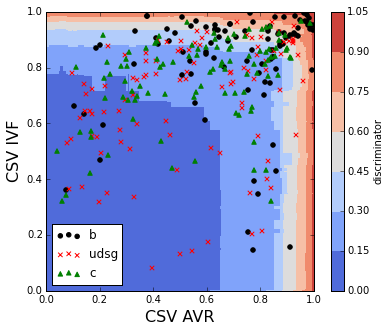

In [165]:
plt.figure(figsize=(6,5))
xx, yy = np.meshgrid(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000))
N = len(xx.ravel())
a = np.c_[xx.ravel(), yy.ravel()]
b = np.zeros((N, 6))
b[:, 0:2] = a[:, :]
bd_jp = 0.4
bd_sel = 0.0
bd_smu = 0.0
vtxcat = 0
b[:, 2] = bd_jp
b[:, 3] = bd_sel
b[:, 4] = bd_smu
b[:, 5] = bd_smu


Z = cls_c3.cls.predict_proba(b)
z = Z[:, 1]
z = z.reshape(xx.shape)
cont = plt.contourf(xx, yy, z, alpha=1, cmap="coolwarm")
plt.colorbar(cont, label="discriminator")
Nplot = 100
sel = (
    (d_testing["Jet_JP"]>bd_jp-0.1) & (d_testing["Jet_JP"]<bd_jp+0.1) &
    (d_testing["Jet_SoftEl"]>bd_sel-0.1) & (d_testing["Jet_SoftEl"]<bd_sel+0.1) &
    (d_testing["Jet_SoftMu"]>bd_smu-0.1) & (d_testing["Jet_SoftMu"]<bd_smu+0.1) & 
    abs(d_testing["Jet_CSV"] - d_testing["Jet_CSVIVF"])>0.00001
)

print sum(sel)
s1 = d_testing["id"]==2
s2 = d_testing["id"]==0
s3 = d_testing["id"]==1

plt.scatter(
    d_testing[sel & s1][:Nplot]["Jet_CSV"],
    d_testing[sel & s1][:Nplot]["Jet_CSVIVF"],
    marker="o", alpha=1.0, color="black",
    label="b"
)

plt.scatter(
    d_testing[sel & s2][:Nplot]["Jet_CSV"],
    d_testing[sel & s2][:Nplot]["Jet_CSVIVF"],
    marker="x", alpha=1.0, color="red",
    label="udsg"
)

plt.scatter(
    d_testing[sel & s3][:Nplot]["Jet_CSV"],
    d_testing[sel & s3][:Nplot]["Jet_CSVIVF"],
    marker="^", alpha=1.0, color="green",
    label="c"
)
plt.legend(numpoints=1, loc=3)
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("CSV AVR", fontsize=16)
plt.ylabel("CSV IVF", fontsize=16)

In [ ]:
# evaluate_tmva(d, "CombinedMVAETH.weights.xml", cls_c3.variables)